In [34]:
#datasets
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
!gunzip -v <../data/K562_2000_merged_histones_init.csv.gz> ../data/K562_2000_merged_histones_init.csv
df = pd.read_csv('/home/amir/my_codes/repli1D/data/K562_2000_merged_histones_init.csv')
df_hela = pd.read_csv('/home/amir/my_codes/mv_seq_to_seq_regression/data/Hela_2000_merged_histones_init.csv')
df_gm06990 = pd.read_csv('/home/amir/my_codes/mv_seq_to_seq_regression/data/GM06990_2000_merged_histones_init.csv')

             H3K4me1   H3K4me3  H3K27me3  H3K36me3   H3K9me3     H2A.Z  \
H3K4me1     1.000000  0.528963  0.083924  0.310683  0.259684  0.513552   
H3K4me3     0.528963  1.000000  0.077340  0.219366  0.231912  0.728134   
H3K27me3    0.083924  0.077340  1.000000 -0.048197  0.248999  0.136302   
H3K36me3    0.310683  0.219366 -0.048197  1.000000  0.288534  0.060612   
H3K9me3     0.259684  0.231912  0.248999  0.288534  1.000000  0.190821   
H2A.Z       0.513552  0.728134  0.136302  0.060612  0.190821  1.000000   
H3K79me2    0.454592  0.734291 -0.060156  0.381687  0.170277  0.319472   
H3K9ac      0.409057  0.879587  0.030909  0.144265  0.112301  0.682245   
H3K4me2     0.721272  0.889616  0.053771  0.210996  0.172271  0.728558   
H3K27ac     0.612444  0.750765 -0.027567  0.177338  0.133874  0.582836   
H4K20me1    0.332790  0.277994  0.461283  0.496312  0.324126  0.169215   
initiation  0.272187  0.183834  0.009172  0.012357  0.065641  0.230227   

            H3K79me2    H3K9ac   H3K4

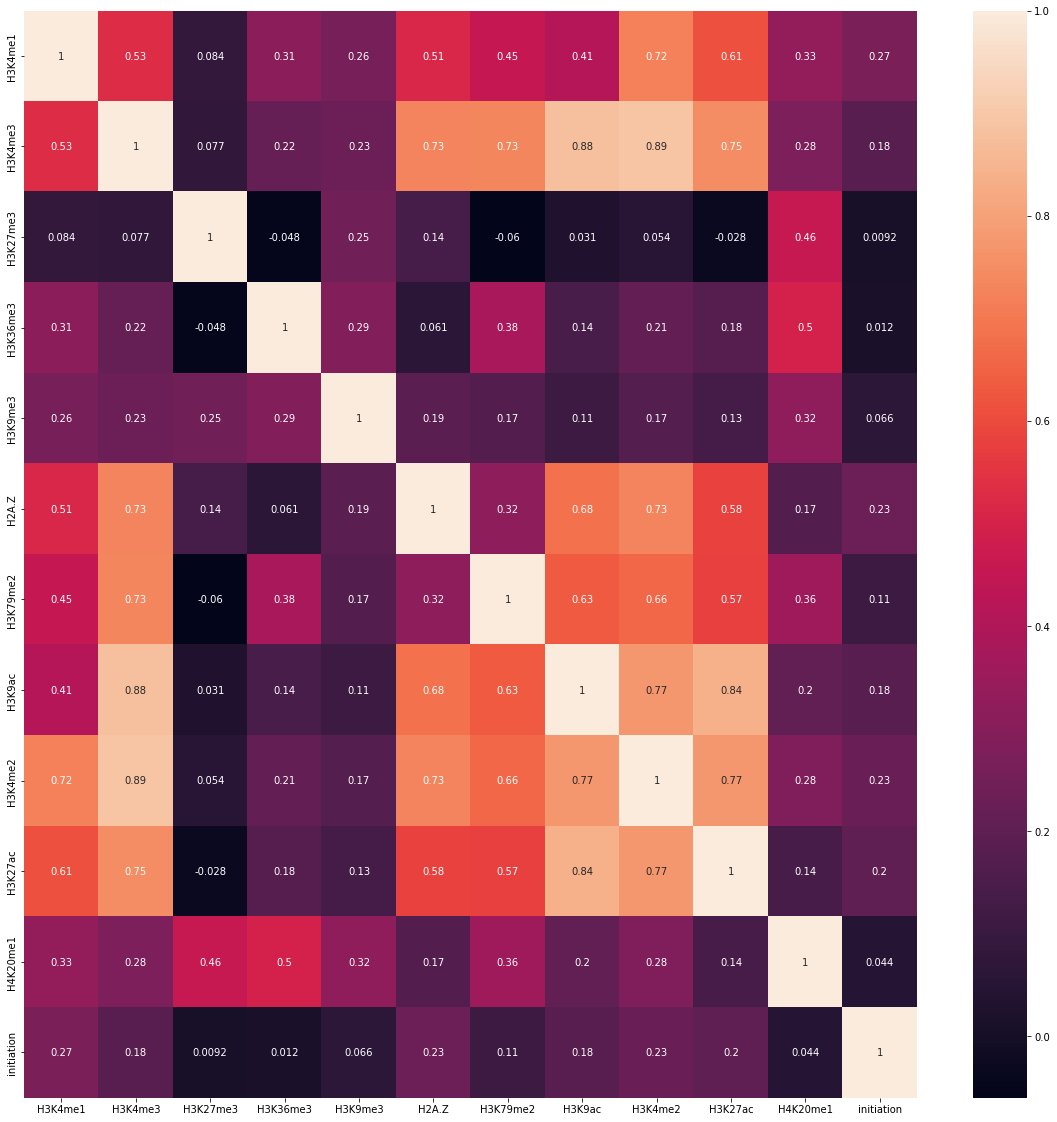

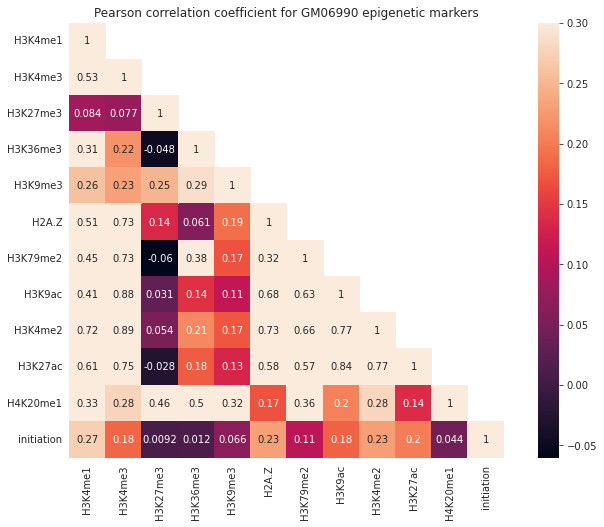

In [27]:
# !pip install seaborn
import seaborn as sns
df_test = df[df.chrom == 'chr1']
# df_val = df[df.chrom == 'chr2']
df_train = df[df.chrom != 'chr1']
#Pearson's Correlation Matrix
df = df # change it to other datasets like hela, K562, etc.
corrMatrix = df.drop(['chromEnd', 'chromStart'], axis=1).corr(method='pearson')
print(corrMatrix)
plt.figure(figsize=(20,20))
sns.heatmap(corrMatrix, annot=True)
mask = np.ones_like(corrMatrix)
mask = np.tril(mask)
mask = np.ones_like(corrMatrix) - mask
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(12, 8))
    ax = sns.heatmap(corrMatrix, mask=mask, vmax=.3, square=True, annot=True)
plt.title("Pearson correlation coefficient for K562+Hela+GM06990 epigenetic markers")
plt.savefig('/home/amir/my_codes/mv_seq_to_seq_regression/fcnn/fcnn_results/pearson_correlation_K562_Hela_GM06990.png', dpi=300, bbox_inches='tight', transparent=False)

In [15]:
from repli1d.nn import load_signal, transform_seq, dev_transform, normal_seq, window_stack
marks = ["H3K4me1", "H3K4me3", "H3K27me3", "H3K36me3",
                         "H3K9me3","H2A.Z","H3K79me2","H3K9ac","H3K4me2","H3K27ac","H4K20me1"]
X_train_scaled, y_train_scaled, notnan = load_signal(df_train,
                                marks=marks,
                                targets=["initiation"],
                                t_norm=normal_seq, smm=5,wig=False)
# X_val_scaled, y_val_scaled, notnan = load_signal(df_val,
#                                 marks=marks,
#                                 targets=["initiation"],
#                                 t_norm=dev_transform, smm=5,wig=False)
X_test_scaled, y_test_scaled, notnan = load_signal(df_test,
                                marks=marks,
                                targets=["initiation"],
                                t_norm=dev_transform, smm=5,wig=False)
V_train_stacked = transform_seq(X_train_scaled, y_train_scaled, 1, 101)
# V_val_stacked = transform_seq(X_val_scaled, y_val_scaled, 1, 101)
V_test_stacked = transform_seq(X_test_scaled, y_test_scaled, 1, 101)

         initiation       H3K4me1       H3K4me3      H3K27me3      H3K36me3  \
count  1.315880e+06  1.315880e+06  1.315880e+06  1.315880e+06  1.315880e+06   
mean   9.978332e-01  1.679456e+01  1.346471e+01  1.234080e+01  1.347271e+01   
std    2.961363e+00  3.408967e+01  3.966381e+01  1.327979e+01  1.929735e+01   
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    1.042000e-01  4.000000e+00  5.000000e+00  5.000000e+00  5.000000e+00   
50%    2.192000e-01  7.000000e+00  8.000000e+00  9.000000e+00  8.000000e+00   
75%    5.358000e-01  1.400000e+01  1.100000e+01  1.600000e+01  1.300000e+01   
max    5.712940e+01  1.657000e+03  2.353000e+03  1.369000e+03  1.362000e+03   

            H3K9me3         H2A.Z      H3K79me2        H3K9ac       H3K4me2  \
count  1.315880e+06  1.315880e+06  1.315880e+06  1.315880e+06  1.315880e+06   
mean   1.983172e+01  2.244081e+01  2.114686e+01  1.707454e+01  1.250841e+01   
std    1.485860e+01  4.320246e+01  8.201218e+01  5.

In [16]:
from repli1d.models import jm_cnn_model, cnn_model
from sklearn.utils import shuffle

X_train_scaled_ws = V_train_stacked[0]
y_train_scaled_ws = V_train_stacked[1]
# X_train_scaled_ws, y_train_scaled_ws = shuffle(X_train_scaled_ws, y_train_scaled_ws, random_state=64)
model = jm_cnn_model(X_train_scaled_ws, y_train_scaled_ws, 15, 10)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 1, 92, 15)         1665      
_________________________________________________________________
activation_4 (Activation)    (None, 1, 92, 15)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 1, 92, 15)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 1, 83, 15)         2265      
_________________________________________________________________
activation_5 (Activation)    (None, 1, 83, 15)         0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 1, 83, 15)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 74, 15)        

In [18]:
y_train_original_stacked = transform_seq(X_train_scaled, df_train['initiation'].to_numpy(copy=True).reshape(-1, 1), 1, 101)[1]
y_test_original_stacked = transform_seq(X_test_scaled, df_test['initiation'].to_numpy(copy=True).reshape(-1, 1), 1, 101)[1]

In [19]:
from keras.callbacks import (EarlyStopping, History, ModelCheckpoint, ReduceLROnPlateau)
history = model.fit(X_train_scaled_ws, y_train_scaled_ws,
                           batch_size=1, epochs=40, verbose=1,
                           callbacks=[History(), ModelCheckpoint(save_best_only=True,
                           filepath=r'/home/amir/my_codes/mv_seq_to_seq_regression/cnn/cnn_results/implemented_same_as_jm'+"/sweights.{epoch:02d}-{val_loss:.4f}.hdf5",
                           verbose=1), EarlyStopping(monitor='loss' , patience=3)],
                           validation_split= 0.1)
                        #    validation_data=(V_val_stacked[0], V_val_stacked[1]))

KeyboardInterrupt: 

In [39]:
# !pip install pydot
tf.keras.utils.plot_model(model, to_file=r'/home/amir/my_codes/mv_seq_to_seq_regression/cnn/cnn_results/implemented_same_as_jm/model_summary.png', show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


dict_keys(['loss', 'val_loss'])


/home/amir/anaconda3/envs/repli/lib/python3.6/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_color" which is no longer supported as of 3.3 and will become an error two minor releases later
  if __name__ == '__main__':


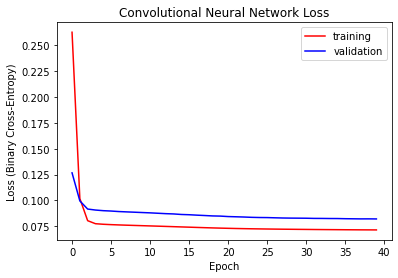

In [8]:
print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'], c='red')
plt.plot(history.history['val_loss'], c='blue')
plt.title('Convolutional Neural Network Loss')
plt.ylabel('Loss (Binary Cross-Entropy)')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.savefig('/home/amir/my_codes/mv_seq_to_seq_regression/cnn/cnn_results/implemented_same_as_jm/CNN_Loss.png', dpi=300, bbox_inches='tight', bbox_color = 'white')

In [151]:
import tensorflow as tf
model = tf.keras.models.load_model('adress of saved model')

In [11]:
import copy
import tensorflow as tf
#Computing the error of the Training Set
RMSE1= tf.keras.metrics.RootMeanSquaredError()
predictions1 = model.predict(X_train_scaled_ws) # uncomment this
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from repli1d.nn import inv_transform

y1 = y_train_original_stacked

unscaled_output_nn_train=copy.deepcopy(inv_transform(predictions1)).reshape(-1, 1)
unscaled_output_nn_test=copy.deepcopy(inv_transform(model.predict(V_test_stacked[0]))).reshape(-1, 1)
results = {}
i=0
print('training set score for parameter number {}:'.format(i+1), r2_score(y1, unscaled_output_nn_train))
results['training set score'] = r2_score(y1, unscaled_output_nn_train)
print('training set MAE for parameter number {}:'.format(i+1),  mean_absolute_error(y1, unscaled_output_nn_train))
results['training set MAE'] = mean_absolute_error(y1, unscaled_output_nn_train)
print('training set MSE for parameter number {}:'.format(i+1),  mean_squared_error(y1, unscaled_output_nn_train))
results['training set MSE'] = mean_squared_error(y1, unscaled_output_nn_train)
print('training set RMSE for parameter number {}:'.format(i+1),  np.sqrt(mean_squared_error(y1, unscaled_output_nn_train)))
results['training set RMSE'] = np.sqrt(mean_squared_error(y1, unscaled_output_nn_train))
print('test set score for parameter number {}:'.format(i+1), r2_score(y_test_original_stacked.reshape(-1,1), unscaled_output_nn_test))
results['test set score'] = r2_score(y_test_original_stacked.reshape(-1,1), unscaled_output_nn_test)
print('test set MAE for parameter number {}:'.format(i+1), mean_absolute_error(y_test_original_stacked.reshape(-1,1), unscaled_output_nn_test))
results['test set MAE'] = mean_absolute_error(y_test_original_stacked.reshape(-1,1), unscaled_output_nn_test)
print('test set MSE for parameter number {}:'.format(i+1), mean_squared_error(y_test_original_stacked.reshape(-1,1), unscaled_output_nn_test))
results['test set MSE'] = mean_squared_error(y_test_original_stacked.reshape(-1,1), unscaled_output_nn_test)
print('test set RMSE for parameter number {}:'.format(i+1),  np.sqrt(mean_squared_error(y_test_original_stacked.reshape(-1,1), unscaled_output_nn_test)))
results['test set RMSE'] = np.sqrt(mean_squared_error(y_test_original_stacked, unscaled_output_nn_test))

results_df = pd.DataFrame(results, index=[0])
results_df.to_excel('/home/amir/my_codes/mv_seq_to_seq_regression/cnn/cnn_results/implemented_same_as_jm/results.xlsx')

training set score for parameter number 1: 0.36720922596528516
training set MAE for parameter number 1: 0.7029731093701393
training set MSE for parameter number 1: 5.479557225513441
training set RMSE for parameter number 1: 2.3408454082902272
test set score for parameter number 1: 0.44166198561179615
test set MAE for parameter number 1: 0.7111990841995735
test set MSE for parameter number 1: 4.214744812860073
test set RMSE for parameter number 1: 2.0529843674173636


/home/amir/anaconda3/envs/repli/lib/python3.6/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_color" which is no longer supported as of 3.3 and will become an error two minor releases later
  


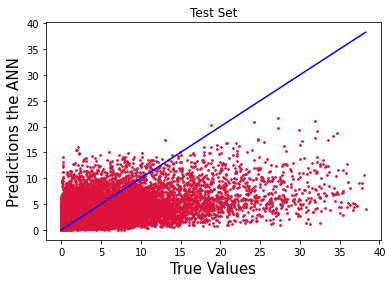

/home/amir/anaconda3/envs/repli/lib/python3.6/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_color" which is no longer supported as of 3.3 and will become an error two minor releases later


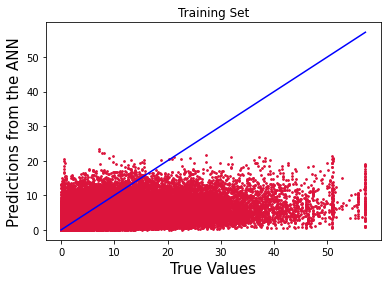

In [12]:
plt.scatter(y_test_original_stacked.reshape(-1,1), unscaled_output_nn_test, c='crimson', s=3)
p1 = max(max(unscaled_output_nn_test), max(y_test_original_stacked.reshape(-1,1)))
p2 = min(min(unscaled_output_nn_test), min(y_test_original_stacked.reshape(-1,1)))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions the ANN', fontsize=15)
plt.title('Test Set')
plt.savefig('/home/amir/my_codes/mv_seq_to_seq_regression/cnn/cnn_results/implemented_same_as_jm/test_true.png', dpi=300, bbox_inches='tight', bbox_color = 'white')
plt.show()
plt.scatter(y1, unscaled_output_nn_train, c='crimson', s=3)
p1 = max(max(unscaled_output_nn_train), max(y1))
p2 = min(min(unscaled_output_nn_train), min(y1))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions from the ANN', fontsize=15)
plt.title('Training Set')
plt.savefig('/home/amir/my_codes/mv_seq_to_seq_regression/cnn/cnn_results/implemented_same_as_jm/train-true.png', dpi=300, bbox_inches='tight', bbox_color = 'white')


[[0.        ]
 [0.        ]
 [0.        ]
 ...
 [1.07403272]
 [0.8855057 ]
 [0.89693158]]
[[0.98262568]
 [0.93120922]
 [0.96548686]
 ...
 [0.        ]
 [0.        ]
 [0.        ]]


/tmp/ipykernel_17124/3919567871.py:18: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_color" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('/home/amir/my_codes/mv_seq_to_seq_regression/jean_michel_cnn/jean_michel_cnn_results/test_true.png', dpi=300, bbox_inches='tight', bbox_color = 'white')


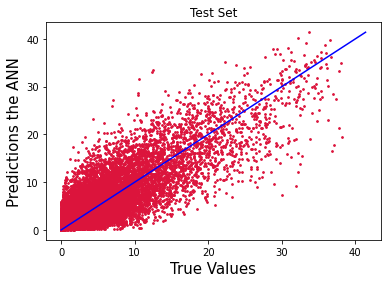

/home/amir/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
/tmp/ipykernel_17124/3919567871.py:27: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_color" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('/home/amir/my_codes/mv_seq_to_seq_regression/jean_michel_cnn/jean_michel_cnn_results/train_true.png', dpi=300, bbox_inches='tight', bbox_color = 'white')


training set score for parameter number 1: 0.7716353657168391
training set MAE for parameter number 1: 0.5776539740329362
training set MSE for parameter number 1: 2.002681420818557
training set RMSE for parameter number 1: 1.415161270251047
test set score for parameter number 1: 0.7438309565784302
test set MAE for parameter number 1: 0.6556547197268606
test set MSE for parameter number 1: 1.9334033769580519
test set RMSE for parameter number 1: 1.3904687615901523
test set DCorr for parameter number 1: 0.8443268166660305 



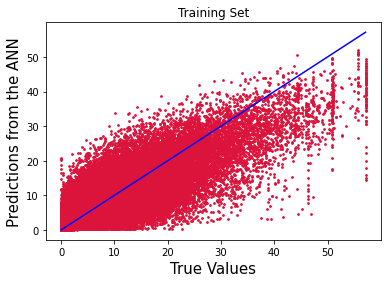

In [202]:
#jean-michel results
y_train_1 = df_train[['initiation']].to_numpy()
# unscaled_cnn_outputs = cnn_outputs['signalValue']*max(y.to_numpy())
cnn_output_test = cnn_outputs[cnn_outputs.chrom == 'chr1']['signalValue']
cnn_output_test = cnn_output_test.to_numpy().reshape(-1,1)*max(y.to_numpy())
print(cnn_output_test)
cnn_output_train = cnn_outputs[cnn_outputs.chrom != 'chr1']['signalValue']
cnn_output_train = cnn_output_train.to_numpy().reshape(-1,1)*max(y.to_numpy())
print(cnn_output_train)

plt.scatter(y_test, cnn_output_test, c='crimson', s=3)
p1 = max(np.max(cnn_output_test), max(y_test))
p2 = min(np.min(cnn_output_test), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions the ANN', fontsize=15)
plt.title('Test Set')
plt.savefig('/home/amir/my_codes/mv_seq_to_seq_regression/jean_michel_cnn/jean_michel_cnn_results/test_true.png', dpi=300, bbox_inches='tight', bbox_color = 'white')
plt.show()
plt.scatter(y_train_1, cnn_output_train, c='crimson', s=3)
p1 = max(np.max(cnn_output_train), max(y_train_1))
p2 = min(np.min(cnn_output_train), min(y_train_1))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions from the ANN', fontsize=15)
plt.title('Training Set')
plt.savefig('/home/amir/my_codes/mv_seq_to_seq_regression/jean_michel_cnn/jean_michel_cnn_results/train_true.png', dpi=300, bbox_inches='tight', bbox_color = 'white')

# print('Weighted average of training set score and test set score:',(r2_score(y_test, pg)+4*r2_score(scaler_y.inverse_transform(y_train), predictions1))/5)
for i in range(y_train_1.shape[1]):
  print('training set score for parameter number {}:'.format(i+1), r2_score(y_train_1.reshape(-1,1)[:,i], cnn_output_train[:,i]))
  results['training set score'] = r2_score(y_train_1[:,i], cnn_output_train[:,i])
  print('training set MAE for parameter number {}:'.format(i+1),  mean_absolute_error(y_train_1.reshape(-1,1)[:,i], cnn_output_train[:,i]))
  results['training set MAE'] = mean_absolute_error(y_train_1.reshape(-1,1)[:,i], cnn_output_train[:,i])
  print('training set MSE for parameter number {}:'.format(i+1), mean_squared_error(y_train_1.reshape(-1,1)[:,i], cnn_output_train[:,i]))
  results['training set MSE'] = mean_squared_error(y_train_1.reshape(-1,1)[:,i], cnn_output_train[:,i])
  print('training set RMSE for parameter number {}:'.format(i+1),  np.sqrt(mean_squared_error(y_train_1.reshape(-1,1)[:,i], cnn_output_train[:,i])))
  results['training set RMSE'] = np.sqrt(mean_squared_error(y_train_1.reshape(-1,1)[:,i], cnn_output_train[:,i]))
  print('test set score for parameter number {}:'.format(i+1), r2_score(y_test.reshape(-1,1)[:,i], cnn_output_test[:,i]))
  results['test set score'] = r2_score(y_test.reshape(-1,1)[:,i],  cnn_output_test[:,i])
  print('test set MAE for parameter number {}:'.format(i+1), mean_absolute_error(y_test.reshape(-1,1)[:,i], cnn_output_test[:,i]))
  results['test set MAE'] = mean_absolute_error(y_test.reshape(-1,1)[:,i], cnn_output_test[:,i])
  print('test set MSE for parameter number {}:'.format(i+1),  mean_squared_error(y_test.reshape(-1,1)[:,i], cnn_output_test[:,i]))
  results['test set MSE'] = mean_squared_error(y_test.reshape(-1,1)[:,i], cnn_output_test[:,i])
  print('test set RMSE for parameter number {}:'.format(i+1),  np.sqrt(mean_squared_error(y_test.reshape(-1,1)[:,i], cnn_output_test[:,i])))
  results['test set RMSE'] = np.sqrt(mean_squared_error(y_test[:,i], cnn_output_test[:,i]))
  print('test set DCorr for parameter number {}:'.format(i+1),  dcor.distance_correlation( cnn_output_test[:,i], y_test.reshape(-1,1)[:,i]), '\n')
  results['test set DCorr'] = dcor.distance_correlation( cnn_output_test[:,i], y_test.reshape(-1,1)[:,i])
results_df = pd.DataFrame(results, index=[0])
results_df.to_excel('/home/amir/my_codes/mv_seq_to_seq_regression/jean_michel_cnn/jean_michel_cnn_results/results.xlsx')